# Análise Exploratória de Dados

DATASET: Sistema de Informações InfoÁguas da Companhia Ambiental do Estado de São Paulo - CETESB.

OBJETIVO: Visa disponibilizar ao público interessado informações sobre a qualidade das águas do Estado de São Paulo quanto aos Índices de Qualidade das Águas  Superficiais e aos resultados dos parâmetros analisados sistematicamente pela CETESB.

LOCALIZAÇÃO: Unidades de Gerenciamento de Recursos Hidricos (UGRHIs) - 2, 5, 6, 7 e 10 - classificada pela CETESB como área industrializada.

PERÍODO DA COLETA DE DADOS: 1977 à 2019.

DESCRIÇÃO DO DATASET: O dataset original da CETESB baixado da ferramenta web infoáguas, apresenta 26 colunas e aproximadamente 4200 linhas. As colunas dizem respeito basicamente a periodicidade do monitoramento, a localização dos pontos, a situação atual dos pontos (ativo ou não), os parametros e qual o tipo de paramentro (fisico, quimico, microbiologico e outros). Optamos por escolher a área classificada como industrializada pois esta área apresentou uma quantidade de dados adequada para a execução do experimento.

O projeto de pesquisa que tem como objetivo geral predizer parametros da qualidade da água usando aprendizado de máquina, dessa forma, tratamos o conjunto de dados como uma série temporal, assim, a predição retornará o valor do parametro para um período de tempo futuro.

Dessa forma, descrevemos as etapas executadas:



In [57]:
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import math

str_files = '../data/CETESB/'

parameters_WQ = ['coliformes', 'dbo', 'Fosforo', 'nitrogenio', 'od', 'ph', 'solido', 'temperatura', 'turbidez']
parameters_WQ_name = ['Coliformes Termotolerantes', 'DBO (5, 20)', 'Fósforo Total', 'Nitrogênio Total', 'Oxigênio Dissolvido',
                      'pH', 'Sólido Total', 'Temperatura da Água', 'Turbidez']

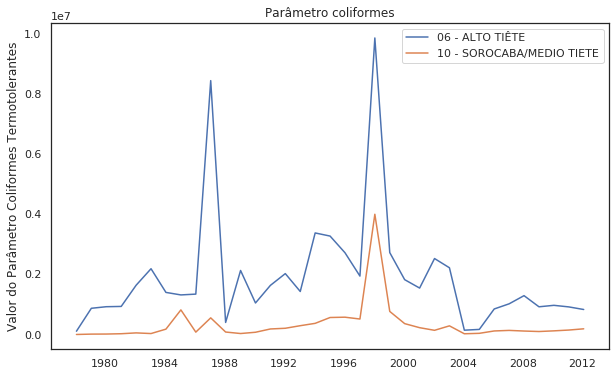

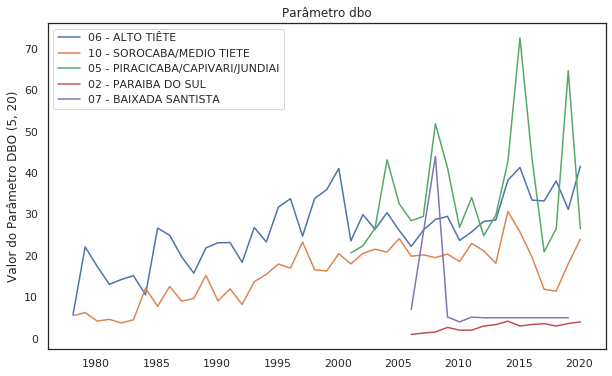

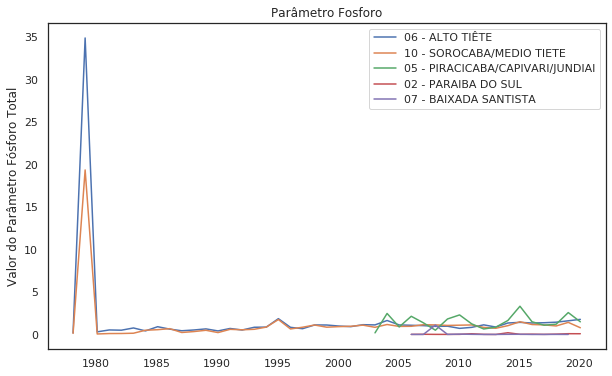

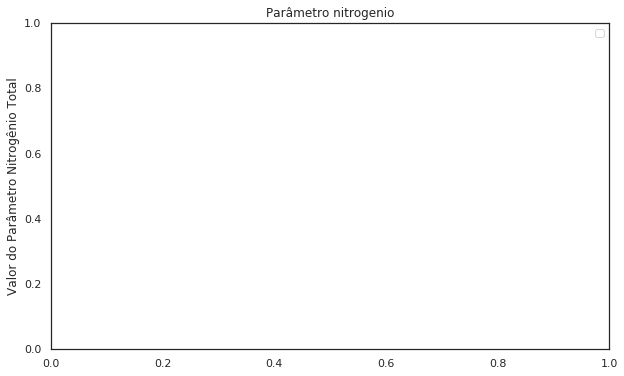

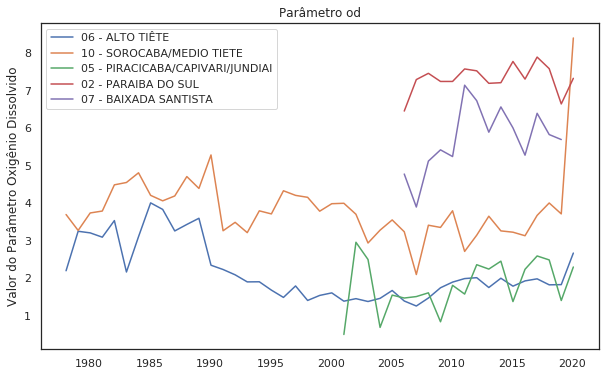

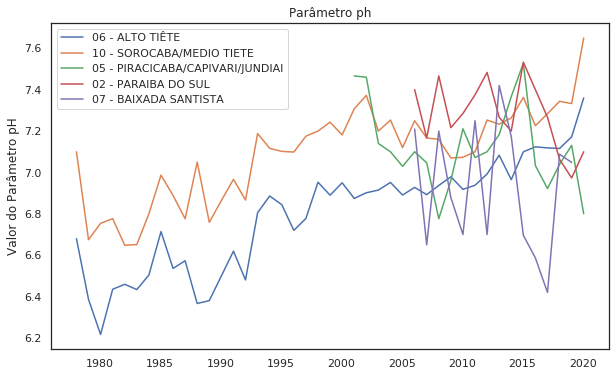

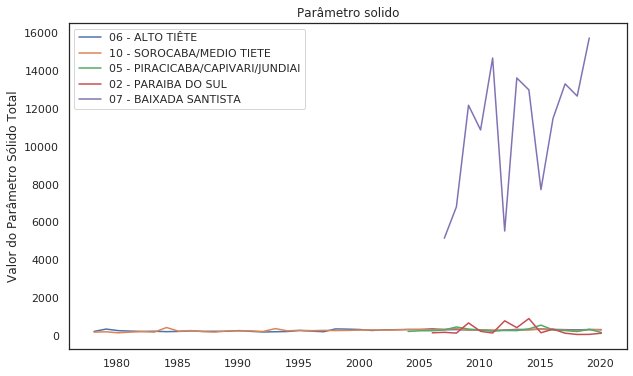

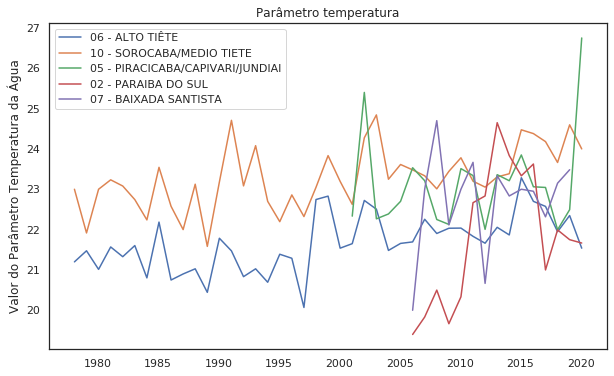

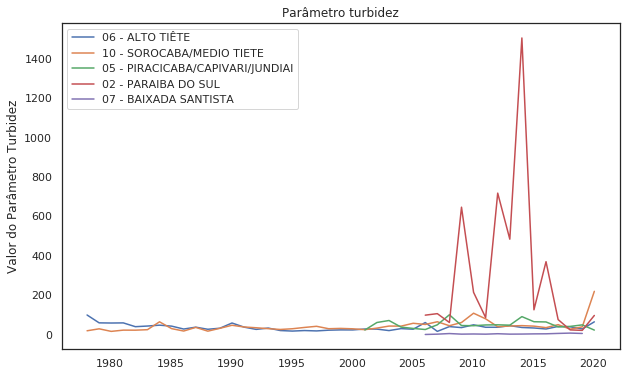

In [58]:



for param_WQ in parameters_WQ:
    df = pd.read_csv(str_files + param_WQ + '.CSV',encoding='utf-8',sep=';')
    
    df['data_coleta'] = pd.to_datetime(df['data_coleta'], format='%d/%m/%Y') 

    df.index = df['data_coleta']
    df_temp = df.groupby([pd.Grouper(freq='12M'), 'UGRHI', 'parametro'], as_index=True ).mean()['valor'].unstack()

    labels_legend = []
    plt.figure(figsize=(10,6)) 
    for i in df_temp.reset_index()['UGRHI'].unique():
        if len(df_temp.reset_index().loc[df_temp.reset_index()['UGRHI'] == i][
            parameters_WQ_name[parameters_WQ.index(param_WQ)]]) > 12:
            
            if param_WQ != 'nitrogenio':
                plt.plot(df_temp.reset_index().loc[df_temp.reset_index()['UGRHI'] == i]['data_coleta'],
                 df_temp.reset_index().loc[df_temp.reset_index()['UGRHI'] == i][parameters_WQ_name[parameters_WQ.index(param_WQ)]])
                labels_legend.append(i)

    plt.title('Parâmetro ' + param_WQ)

    plt.ylabel('Valor do Parâmetro '+ parameters_WQ_name[parameters_WQ.index(param_WQ)])
    plt.legend(labels_legend)
    plt.show()


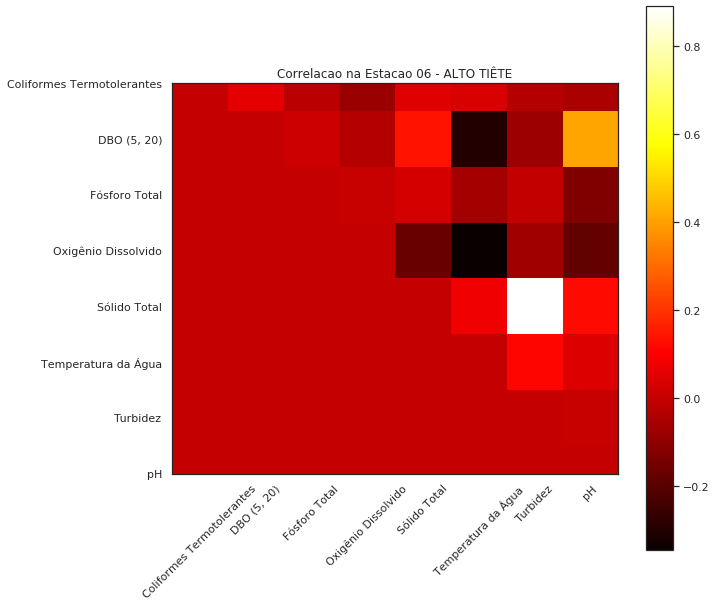

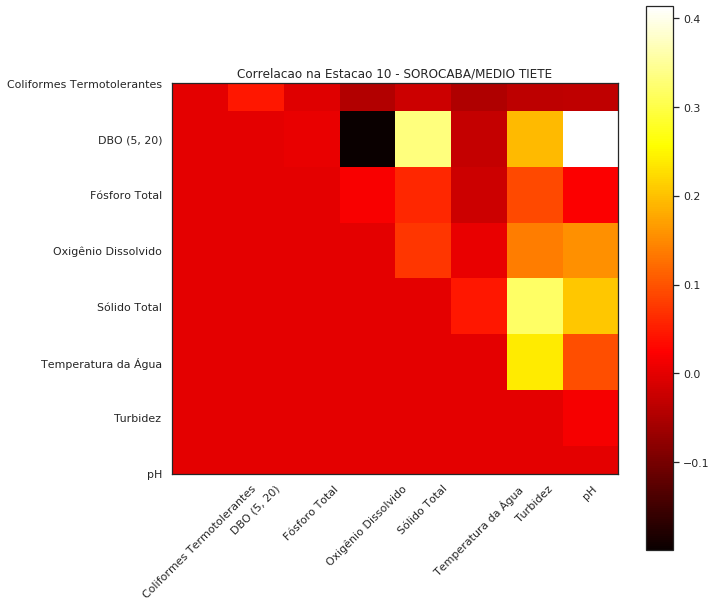

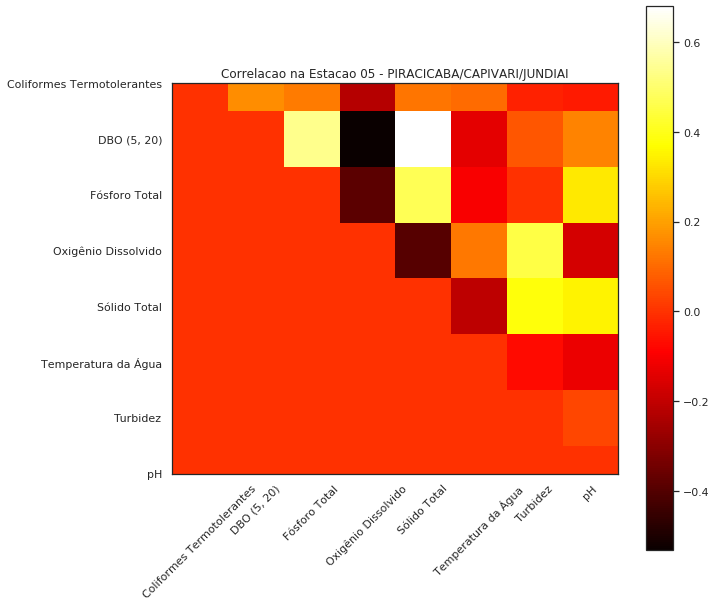

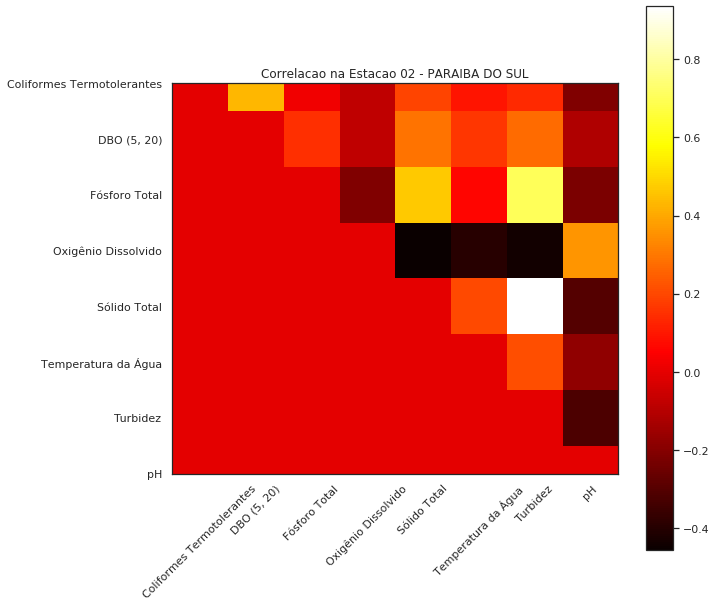

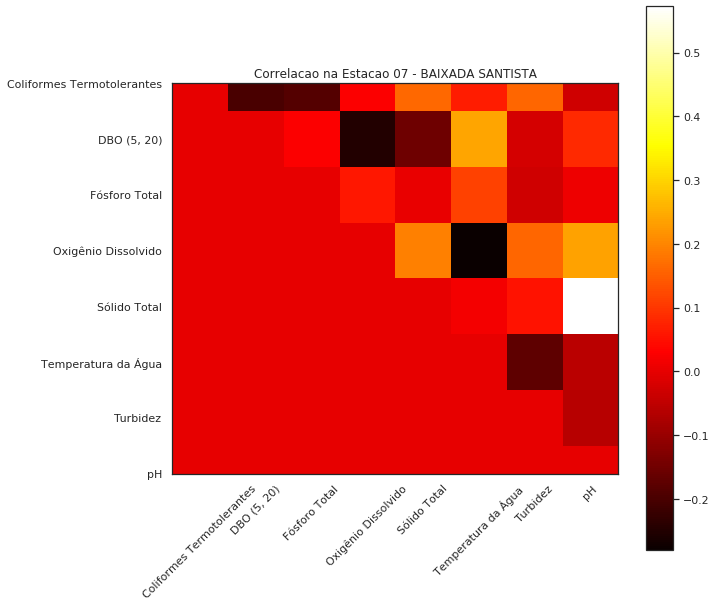

In [59]:
geral_df = pd.DataFrame()
for param_WQ in parameters_WQ:    
    temp_data_file = pd.read_csv(str_files + param_WQ + '.CSV',encoding='utf-8',sep=';')
    
    temp_data_file['data_coleta'] = pd.to_datetime(temp_data_file['data_coleta'], format='%d/%m/%Y') 
    
    geral_df = pd.concat([geral_df,temp_data_file], axis=0, ignore_index=True, sort=False)
    
geral_df.index = geral_df['data_coleta']

grouped_df = geral_df.groupby([pd.Grouper(freq='1M'), 'UGRHI', 'parametro'], 
                                as_index=True ).mean()['valor'].unstack()

grouped_df.drop('Nitrogênio Total', axis=1, inplace=True)

df_corr = grouped_df.transform(lambda x: x.fillna(method='ffill')).dropna().reset_index()
estacoes =  df_corr['UGRHI'].unique()


for i_estacoes in estacoes:    
    df_estacao_corr = df_corr.loc[df_corr['UGRHI'] == i_estacoes]    
    corr = df_estacao_corr.corr()
    
    plt.figure(figsize=(10,10))
    plt.imshow( np.triu(corr, k=1), cmap='hot', interpolation='none')  
    plt.colorbar()  
    plt.title('Correlacao na Estacao ' + i_estacoes)
    plt.xticks(range(len(corr)), corr.columns, rotation=45)  
    plt.yticks(range(len(corr)), corr.columns)
    plt.show()
    

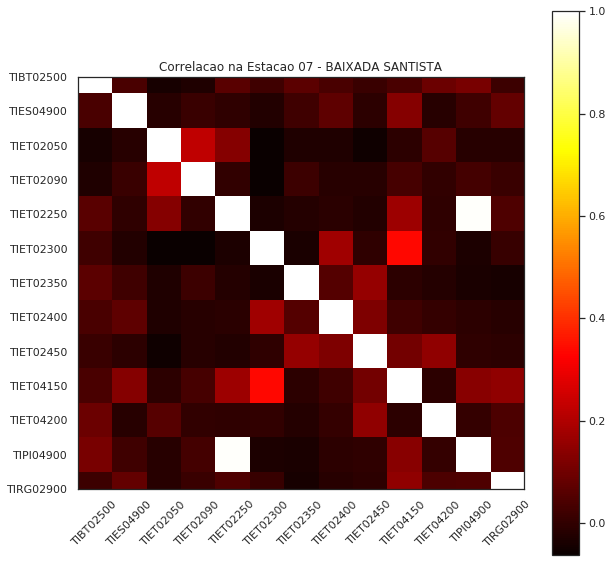

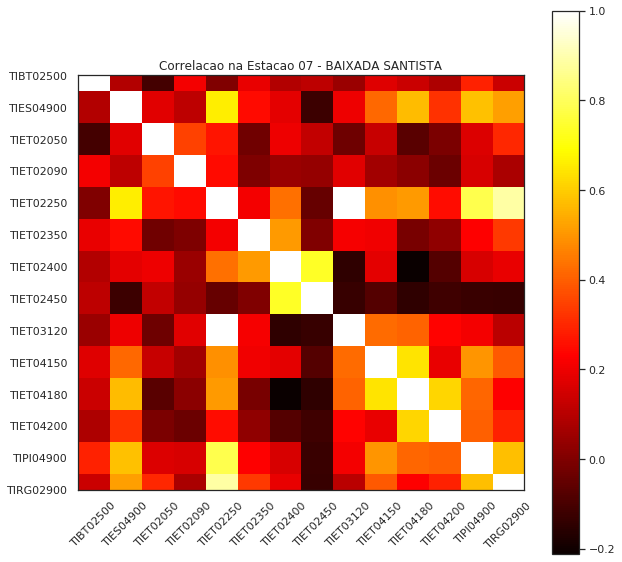

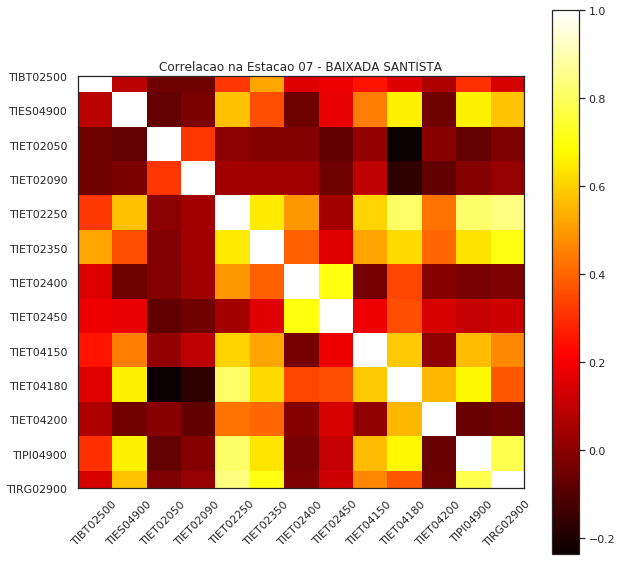

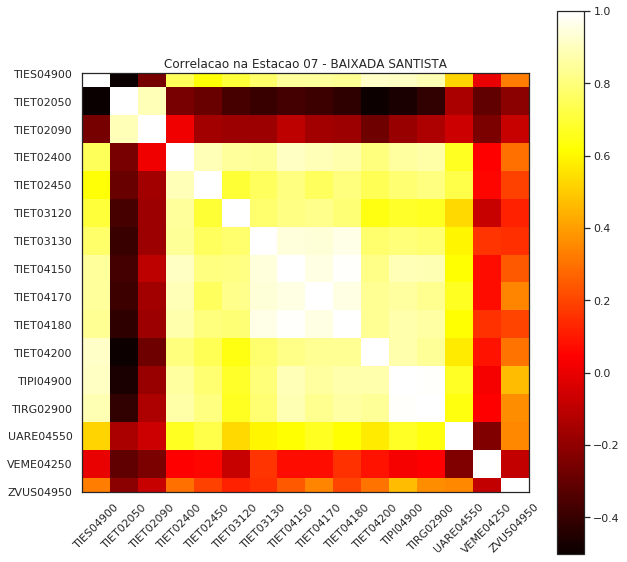

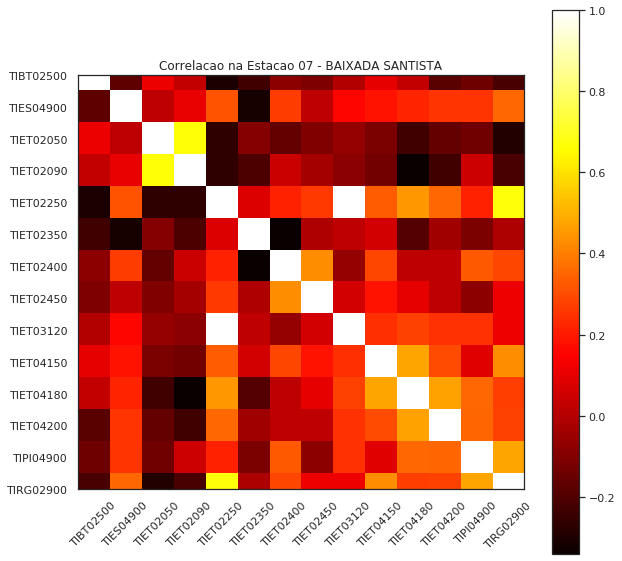

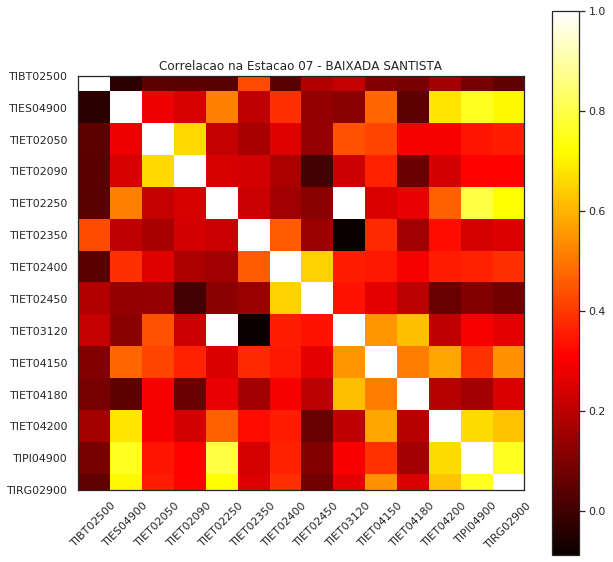

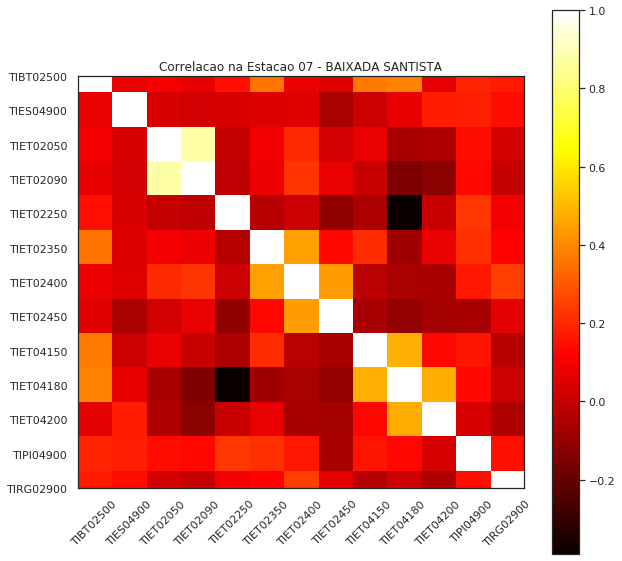

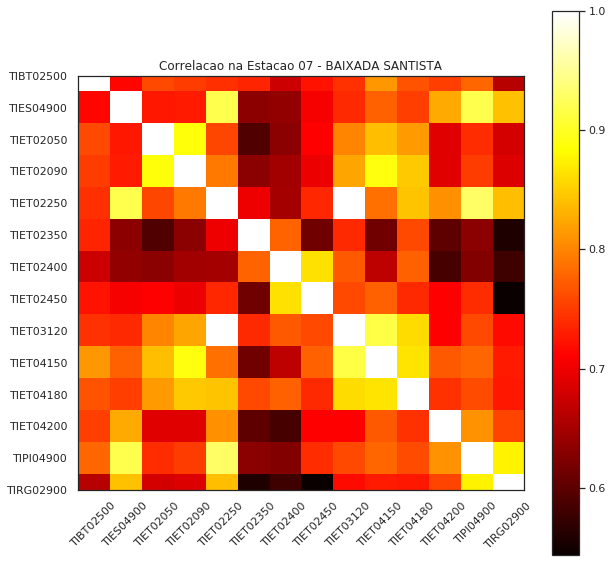

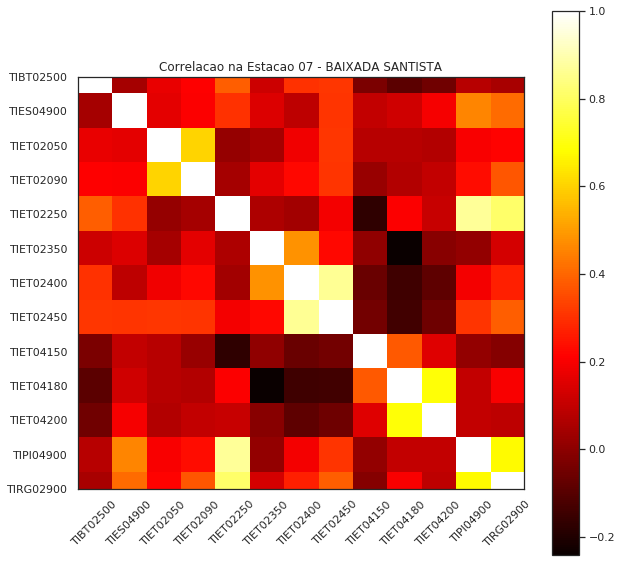

In [60]:

grouped_df_param = geral_df.groupby([pd.Grouper(freq='1M'), 'codigo_ponto', 'parametro'], 
                                as_index=True ).mean()['valor']

grouped_df_param = grouped_df_param.reset_index()



for param_WQ in parameters_WQ_name:
    
    df_temp_param = grouped_df_param.loc[grouped_df_param['parametro'] == param_WQ]
    
    df_temp_param.index = df_temp_param['data_coleta']
    corr = df_temp_param.groupby([pd.Grouper(freq='1M'), 'codigo_ponto'], 
                            as_index=True ).mean()['valor'].unstack()

    corr = corr.loc[ :, corr.isna().mean() < .75].corr()
    
    plt.figure(figsize=(10,10))
    plt.imshow(corr, cmap='hot', interpolation='none')  
    plt.colorbar()  
    plt.title('Correlacao na Estacao ' + i_estacoes)
    plt.xticks(range(len(corr)), corr.columns, rotation=45)  
    plt.yticks(range(len(corr)), corr.columns)
    plt.show()

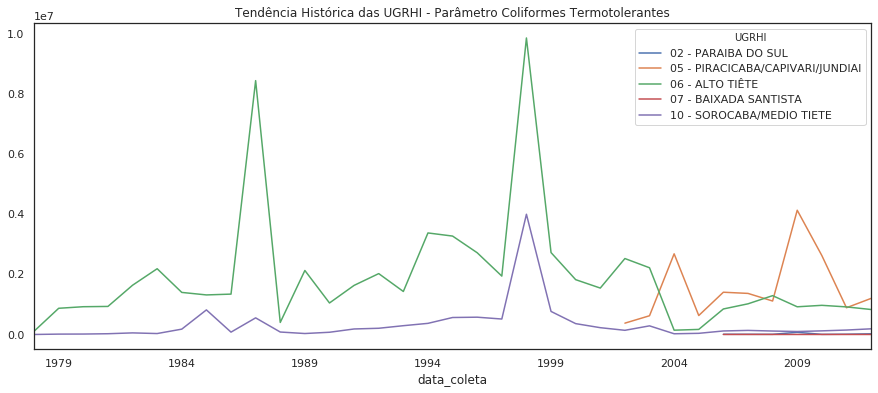

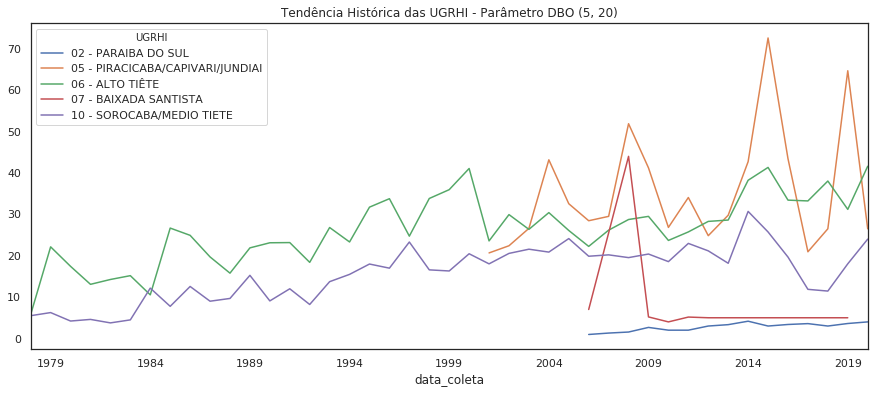

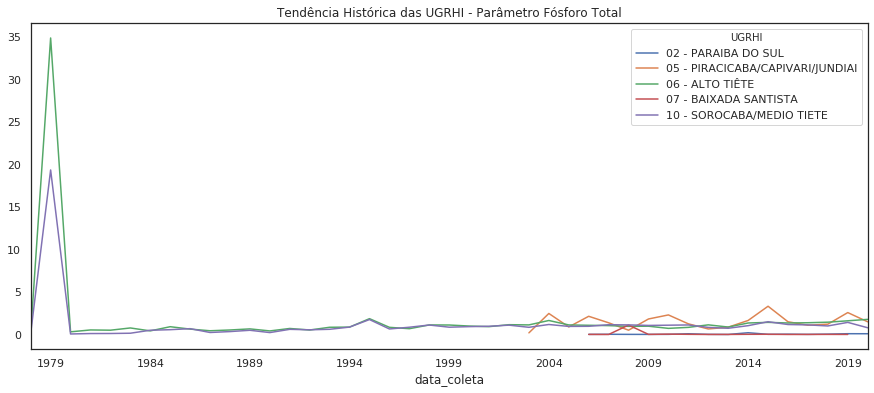

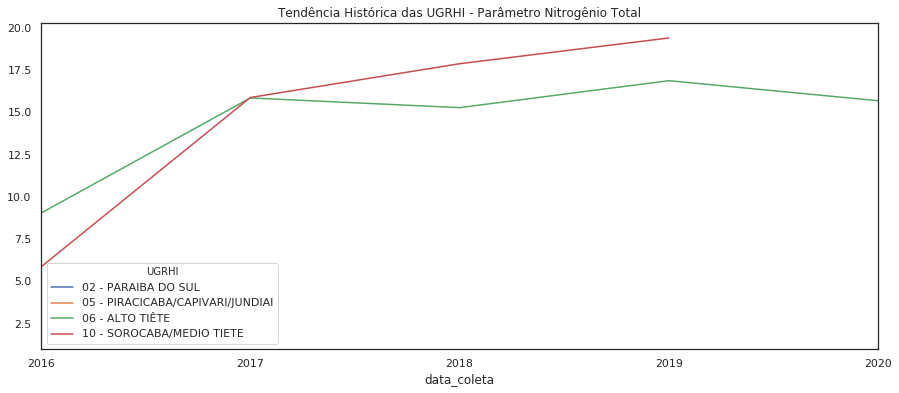

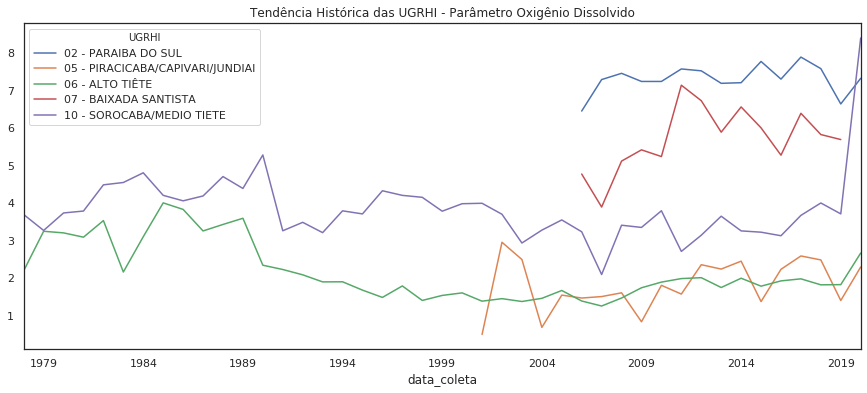

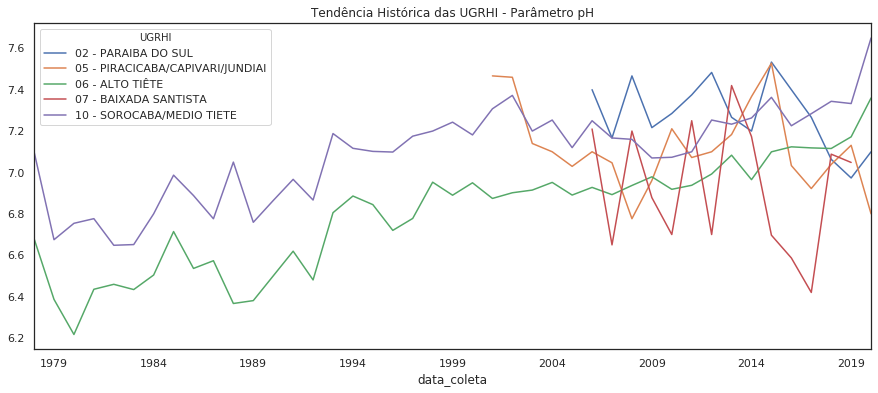

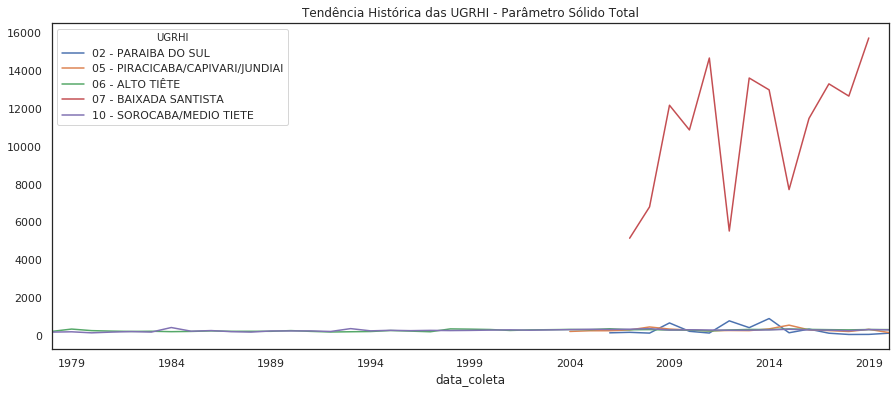

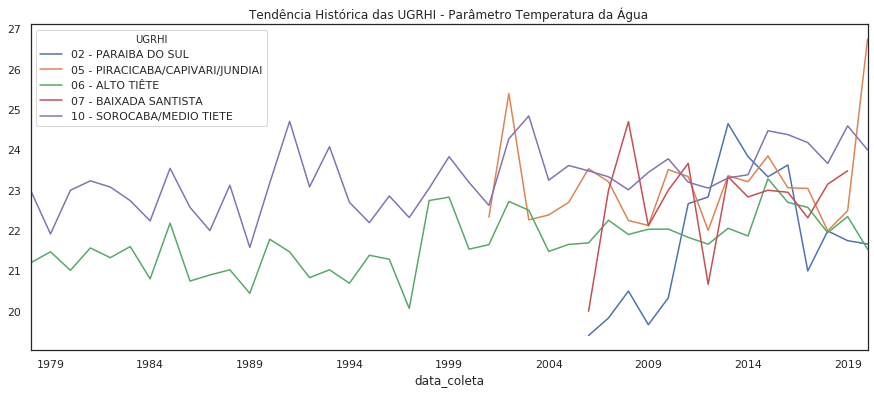

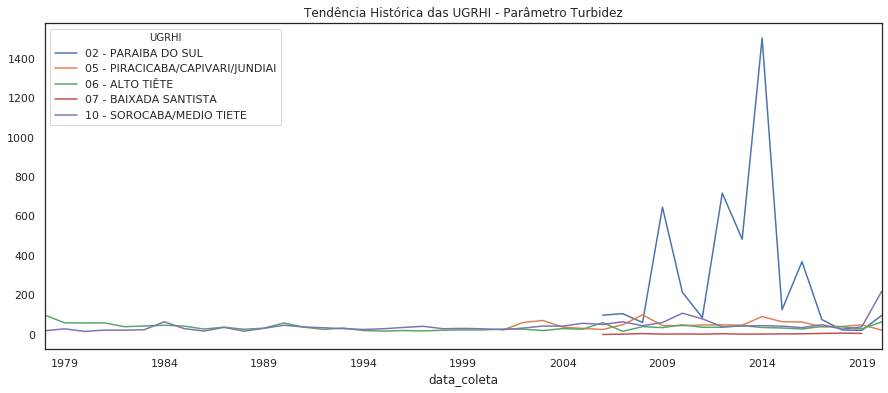

In [61]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

for param_WQ in parameters_WQ_name:
    
    tdf = geral_df.loc[geral_df['parametro'] == param_WQ]
    
    
    
    UGRHI = tdf.UGRHI.values
    
    tdf = tdf[tdf.UGRHI.isin(UGRHI)].groupby([pd.Grouper(freq='12M'), 'UGRHI'], 
                            as_index=True).mean()['valor'].unstack()
    
    tdf.plot(title = 'Tendência Histórica das UGRHI - Parâmetro ' + param_WQ,legend=True)
    plt.show()

In [62]:
pts = geral_df.loc[geral_df['parametro'] == 'pH']['valor']


print("Predição do valor de PH utilizando redes neurais MLP (Multipla Camada)\n Registros no período de 2003 a 2019.")
pts_valor = pts.values
pts_valor = pts_valor.astype('float32')

Predição do valor de PH utilizando redes neurais MLP (Multipla Camada)
 Registros no período de 2003 a 2019.


Numero de observações (dados de treino, dados de teste): (2924, 1254)


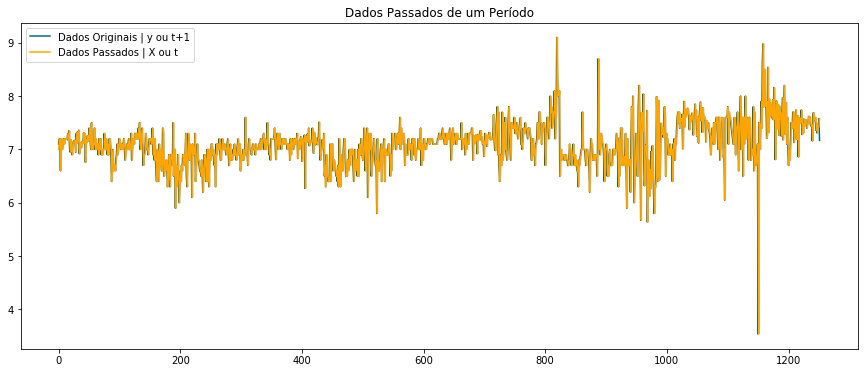

In [7]:
TRAIN_SIZE = 0.70
train_size = int(len(pts_valor) * TRAIN_SIZE)
test_size = len(pts_valor) - train_size
train, test = pts_valor[0:train_size], pts_valor[train_size:len(pts_valor)]
print('Numero de observações (dados de treino, dados de teste): ' + str((len(train),len(test))))

def prepare_data(data, lags=1):
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags)]
        X.append(a)
        y.append(data[row + lags])
    return np.array(X), np.array(y) 

lags = 1
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)
y_true = y_test

plt.plot(y_test, label='Dados Originais | y ou t+1', color='#006699')
plt.plot(X_test, label='Dados Passados | X ou t', color='orange')
plt.legend(loc='upper left')
plt.title('Dados Passados de um Período')
plt.show()

In [8]:
mdl = Sequential()
mdl.add(Dense(4, input_dim=lags, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=100, batch_size=2, verbose=2)

Train on 2922 samples
Epoch 1/100
2922/2922 - 1s - loss: 10.6709
Epoch 2/100
2922/2922 - 1s - loss: 0.1494
Epoch 3/100
2922/2922 - 1s - loss: 0.1495
Epoch 4/100
2922/2922 - 1s - loss: 0.1521
Epoch 5/100
2922/2922 - 1s - loss: 0.1523
Epoch 6/100
2922/2922 - 1s - loss: 0.1519
Epoch 7/100
2922/2922 - 1s - loss: 0.1501
Epoch 8/100
2922/2922 - 1s - loss: 0.1476
Epoch 9/100
2922/2922 - 1s - loss: 0.1478
Epoch 10/100
2922/2922 - 1s - loss: 0.1458
Epoch 11/100
2922/2922 - 1s - loss: 0.1460
Epoch 12/100
2922/2922 - 1s - loss: 0.1464
Epoch 13/100
2922/2922 - 1s - loss: 0.1447
Epoch 14/100
2922/2922 - 1s - loss: 0.1447
Epoch 15/100
2922/2922 - 1s - loss: 0.1457
Epoch 16/100
2922/2922 - 1s - loss: 0.1446
Epoch 17/100
2922/2922 - 1s - loss: 0.1445
Epoch 18/100
2922/2922 - 1s - loss: 0.1446
Epoch 19/100
2922/2922 - 1s - loss: 0.1448
Epoch 20/100
2922/2922 - 1s - loss: 0.1446
Epoch 21/100
2922/2922 - 1s - loss: 0.1432
Epoch 22/100
2922/2922 - 1s - loss: 0.1462
Epoch 23/100
2922/2922 - 1s - loss: 0.14

In [9]:
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Pontuação de Treino: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Pontuação de teste: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Pontuação de Treino: 0.14 MSE (0.37 RMSE)
Pontuação de teste: 0.13 MSE (0.36 RMSE)


In [10]:
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

In [11]:
train_predict_plot = np.empty_like(pts_valor)
train_predict_plot = np.reshape(train_predict_plot,(train_predict_plot.shape[0],1))
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict

In [12]:
test_predict_plot = np.empty_like(pts_valor)
test_predict_plot = np.reshape(test_predict_plot,(test_predict_plot.shape[0],1))
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags*2)+1:len(pts_valor)-1, :] = test_predict

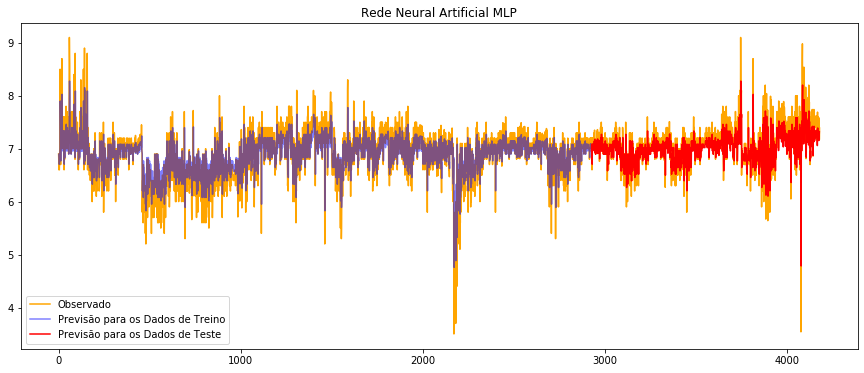

In [13]:
plt.plot(pts_valor, label='Observado', color='orange');
plt.plot(train_predict_plot, label='Previsão para os Dados de Treino', color='blue', alpha=0.5);
plt.plot(test_predict_plot, label='Previsão para os Dados de Teste', color='red');
plt.legend(loc='best');
plt.title('Rede Neural Artificial MLP')
plt.show()